# Kaggle Titanic Competition
The Titanic problem is a great introduction to ML. The problem is simple: predict which passengers aboard the Titanic will survive the shipwreck. My learning outcomes for this project:
1. Familiarisation with the Kaggle API
2. Familiarisation with XGBoost
3. Fun!

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

Download project files from Kaggle. See [here](https://www.kaggle.com/docs/api) if you don't have the Kaggle CLI tools installed.

In [2]:
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 972kB/s]


In [3]:
!unzip -o titanic.zip -d data && rm titanic.zip

Archive:  titanic.zip
  inflating: data/gender_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


## Data Preparation

In [4]:
train_data_raw = pd.read_csv('data/train.csv')
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I will start with a simple model that uses the numerical data only. This means there is no reason to load the Name, Ticket or Cabin fields. The dataframe is also altered to use PassengerId as the key.

In [5]:
train_data = train_data_raw.drop(columns=['Name', 'Ticket', 'Cabin']).set_index('PassengerId')
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


First it's a good idea to check for NULLs. The easiest way to deal with them is to remove them so that is what we will do.

In [6]:
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
train_data = train_data.dropna()
train_data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [8]:
train_data.describe().astype('int32')

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712,712,712,712,712,712
mean,0,2,29,0,0,34
std,0,0,14,0,0,52
min,0,1,0,0,0,0
25%,0,1,20,0,0,8
50%,0,2,28,0,0,15
75%,1,3,38,1,1,33
max,1,3,80,5,6,512


All columns with numerical data are convered to floats between 0 and 1. The categorical columns are one-hot encoded to binary values. It's noted there are 8 categories for SibSp and 6 categories for Parch. These could be treated as categorical values as they are discrete in nature however for simplicity I'm treating them as a continuous variables.

As we are using XGBoost there is no need to apply one-hot encoding to the categorical variables and no need to normalise the inputs. The categorical features of XGBoost are still experimental however. For this reason and the sake of consistancy with other methods I will still apply these techniques here. 

In [9]:
# Create a function to normalise the inputs
def normalise_inputs(series_ref: pd.Series):
    series_ref /= (series_ref.max() - series_ref.min())

# Convert Sex column to float values
train_data['Sex'] = train_data['Sex'].map({'male': 1.0, 'female': 0.0})

# Normalise the age, SibSp, Parch and Fare columns
train_data['SibSp'] = train_data['SibSp'].astype('float32')
train_data['Parch'] = train_data['Parch'].astype('float32')
normalise_inputs(train_data['Age'])
normalise_inputs(train_data['SibSp'])
normalise_inputs(train_data['Parch'])
normalise_inputs(train_data['Fare'])

# Add dummy variables for Pclass. One hot encoding is uses for simplicity (rather than binary)
p_class_one_hot = pd.get_dummies(train_data['Pclass'], prefix='Pclass', dtype='float32')
train_data = train_data.drop(columns='Pclass').join(p_class_one_hot)

# Add dummy variables for Pclass. One hot encoding is uses for simplicity (rather than binary)
embarked_one_hot = pd.get_dummies(train_data['Embarked'], prefix='Embarked', dtype='float32')
train_data = train_data.drop(columns='Embarked').join(embarked_one_hot)

train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,0,1.0,0.276451,0.2,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0.0,0.477507,0.2,0.0,0.139136,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0.0,0.326715,0.0,0.0,0.015469,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.0,0.439809,0.2,0.0,0.103644,1.0,0.0,0.0,0.0,0.0,1.0
5,0,1.0,0.439809,0.0,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0


Let's take another look at the dataset statistics

In [10]:
train_data.describe(percentiles=[]).round(2)

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.0,712.00,712.00,712.00
mean,0.40,0.64,0.37,0.10,0.07,0.07,0.26,0.24,0.5,0.18,0.04,0.78
std,0.49,0.48,0.18,0.19,0.14,0.10,0.44,0.43,0.5,0.39,0.19,0.42
min,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
50%,0.00,1.00,0.35,0.00,0.00,0.03,0.00,0.00,0.0,0.00,0.00,1.00
max,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


In [11]:
# Clip between 0 and 1 for marginal values
train_data = train_data.clip(0, 1)
train_data.describe(percentiles=[]).round(2)

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.0,712.00,712.00,712.00
mean,0.40,0.64,0.37,0.10,0.07,0.07,0.26,0.24,0.5,0.18,0.04,0.78
std,0.49,0.48,0.18,0.19,0.14,0.10,0.44,0.43,0.5,0.39,0.19,0.42
min,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
50%,0.00,1.00,0.35,0.00,0.00,0.03,0.00,0.00,0.0,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


## XGBoost Model Training
The first step of XGBoost is to load the data into an XGBoost DMatrix.

In [12]:
train_dataset = xgb.DMatrix(train_data.drop(columns='Survived'), label=train_data['Survived'])

Now to train the model

In [13]:
param = {'max_depth': 5, 'eta': 0.01, 'objective': 'binary:logistic'}
model = xgb.train(param, train_dataset, 500)

Let's take a look at the feature importance chart and trees

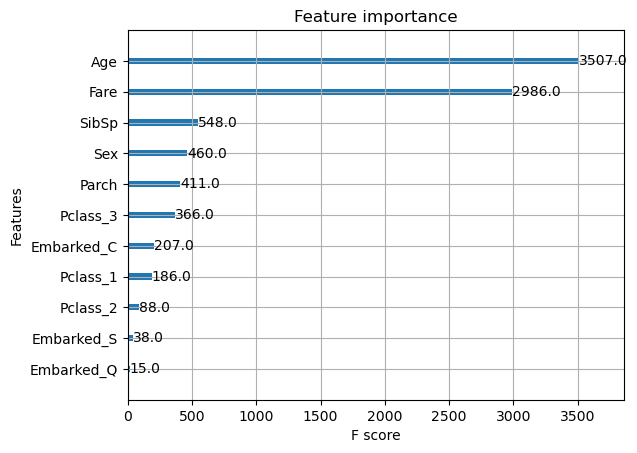

In [14]:
xgb.plot_importance(model);

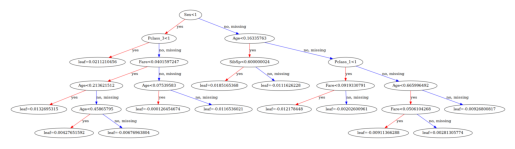

In [15]:
xgb.plot_tree(model, num_trees=2);

# Test Data Preparation

First the test dataset needs to be processed in a similar manner to the test data.

In [16]:
# Load test data and drop unused columns
test_data = pd.read_csv('data/test.csv')
test_data = test_data.drop(columns=['Name', 'Ticket', 'Cabin']).set_index('PassengerId')
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S


In [17]:
# Convert Sex column to float values
test_data['Sex'] = test_data['Sex'].map({'male': 1.0, 'female': 0.0})

# Normalise the age, SibSp, Parch and Fare columns
test_data['SibSp'] = test_data['SibSp'].astype('float32')
test_data['Parch'] = test_data['Parch'].astype('float32')
normalise_inputs(test_data['Age'])
normalise_inputs(test_data['SibSp'])
normalise_inputs(test_data['Parch'])
normalise_inputs(test_data['Fare'])

# Add dummy variables for Pclass. One hot encoding is uses for simplicity (rather than binary)
p_class_one_hot = pd.get_dummies(test_data['Pclass'], prefix='Pclass', dtype='float32')
test_data = test_data.drop(columns='Pclass').join(p_class_one_hot)

# Add dummy variables for Pclass. One hot encoding is uses for simplicity (rather than binary)
embarked_one_hot = pd.get_dummies(test_data['Embarked'], prefix='Embarked', dtype='float32')
test_data = test_data.drop(columns='Embarked').join(embarked_one_hot)

test_data.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
892,1.0,0.454965,0.000,0.000000,0.015282,0.0,0.0,1.0,0.0,1.0,0.0
893,0.0,0.619807,0.125,0.000000,0.013663,0.0,0.0,1.0,0.0,0.0,1.0
894,1.0,0.817618,0.000,0.000000,0.018909,0.0,1.0,0.0,0.0,1.0,0.0
895,1.0,0.356060,0.000,0.000000,0.016908,0.0,0.0,1.0,0.0,0.0,1.0
896,0.0,0.290123,0.125,0.111111,0.023984,0.0,0.0,1.0,0.0,0.0,1.0


In [18]:
# Clip between 0 and 1 for marginal values
test_data = test_data.clip(0, 1)
test_data.describe(percentiles=[]).round(2)

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,418.00,332.00,418.00,418.00,417.00,418.00,418.00,418.00,418.00,418.00,418.00
mean,0.64,0.40,0.06,0.04,0.07,0.26,0.22,0.52,0.24,0.11,0.65
std,0.48,0.19,0.11,0.11,0.11,0.44,0.42,0.50,0.43,0.31,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.36,0.00,0.00,0.03,0.00,0.00,1.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# XGBoost Predictions

In [19]:
# Create test dataset
test_dataset = xgb.DMatrix(test_data)

# Use model to predict outputs
preds = model.predict(test_dataset)
preds = preds.round().astype(int)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

The PassengerIds and predictions are save to a CSV file

In [20]:
test_data_ids = test_data.index.to_numpy()

np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_data_ids, preds]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='PassengerId,Survived',
    comments='',
)

Next the file is submitted to Kaggle and the score is retrieved

In [21]:
!kaggle competitions submit -c titanic -f submission.csv -m "Second Submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 1.70kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [22]:
!sleep 2
!kaggle competitions submissions -c titanic | head -n 3

fileName               date                 description          status    publicScore  privateScore  
---------------------  -------------------  -------------------  --------  -----------  ------------  
submission.csv         2024-07-21 10:52:32  Second Submission    complete  0.77033                    


My first submission for this competition scored 0.76 which is not bad. Let's compare that to the supplied submission that uses the gender column only. This supplied submission is treated as a baseline for the Titanic competition.

In [23]:
!kaggle competitions submit -c titanic -f data/gender_submission.csv -m "Baseline Submission"

100%|██████████████████████████████████████| 3.18k/3.18k [00:00<00:00, 3.38kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [25]:
!sleep 2
!kaggle competitions submissions -c titanic | head -n 4

fileName               date                 description          status    publicScore  privateScore  
---------------------  -------------------  -------------------  --------  -----------  ------------  
gender_submission.csv  2024-07-21 10:52:37  Baseline Submission  complete  0.76555                    
submission.csv         2024-07-21 10:52:32  Second Submission    complete  0.77033                    


My submission performed slightly better than the baseline submission. The next steps are to alter the parameters of the XGBoost model in order to improve model accuracy. From there additional techniques could be used such as feature engineering.